In [75]:
#Importing of necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from googletrans import Translator
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score
import matplotlib.pyplot as plt

In [30]:
#The first step would be to convert the words into bag of word vectors
tweets = pd.read_csv("cleaned_tweets_dataset.csv")

In [31]:
stop = list(stopwords.words('english'))

contextual_stop = ['day','new','one', 'time','need']
stop = stop + contextual_stop
#initialize a lemmatizer
lemmatizer = WordNetLemmatizer()

In [32]:
#Tokenize the words into a list
tweets['tokenized'] = tweets.text.apply(word_tokenize)

In [33]:
#Removed stop words
tweets['processed_data'] = tweets.tokenized.apply(lambda x: [word.casefold() for word in x if word.casefold() not in stop
                                                                    and word not in contextual_stop])
#lemmatize the words
tweets['processed_data'] = tweets.processed_data.apply(lambda x:[lemmatizer.lemmatize(word) for word in x])

tweets['sentence'] = tweets['processed_data'].apply(lambda x : " ".join(x))

In [34]:
#Next, we initialize a count vectorizer and transform the text into Bag of Words vectors
vectorizer = CountVectorizer(max_df = 0.5, min_df = 10)
#Create an array that contains the BOW representation of each tweet
bow_array  = vectorizer.fit_transform(tweets['sentence'])
#Converting the result into a pandas dataframe
bow = pd.DataFrame(bow_array.toarray(),columns = vectorizer.get_feature_names_out())


In [35]:
bow.head()

,00,000,00am,00pm,01,02,03,04,05,06,...,yr,yt,yummy,yup,zealand,zero,zombie,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
#Originally, the proportion of human tweets against bot tweets is as follows:
tweets.account_type.value_counts()

human    42912
bot      10772
Name: account_type, dtype: int64

In [37]:
#Approximately 80% of the tweets are human tweets while the remaining 10772 tweets are bot tweets

In [38]:
#Fitting a simple K means with 2 clusters to see whether there is fundamental differences in BOW vectors between the 2 types
#of tweets
#Keep n = 2 because in our dataset we have 2 obvious clusters (bot tweets and human tweets)
kmeans = KMeans(n_clusters = 2)
kmeans.fit(bow)

KMeans(n_clusters=2)

In [39]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
tweets['clusters'] = kmeans.labels_

In [41]:
#Having a look at the first cluster
first_cluster = tweets[tweets['clusters'] == 1]

In [42]:
#Look at the counts of account type in the first cluster
first_cluster.account_type.value_counts()
#Approximately 85% percent of this cluster comprises of human tweets, which is not a very significant seperation of data

human    1997
bot       350
Name: account_type, dtype: int64

In [43]:
#Have a look at the second cluster
second_cluster = tweets[tweets['clusters'] == 0]

In [44]:
second_cluster.account_type.value_counts()
#As we can see, the proportion of human and bot tweets in this cluster is not very different from the original dataset as well
#Hence, we can conclude that the differences in BOW vectors between bot tweets and human tweets is not very significant

human    40915
bot      10422
Name: account_type, dtype: int64

In [61]:
#Create a numeric column where human accounts are assigned 0 and bot accounts are assigned 1
tweets['account_type_numeric'] = 0
tweets.loc[tweets['account_type'] == 'bot','account_type_numeric'] = 1

In [62]:
#Finally, we can try fitting a logistic regression model using the BOW vectors as the features
X = bow
y = tweets[['account_type_numeric']]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [64]:
log_reg = LogisticRegression(max_iter = 400)

log_reg.fit(X_train, y_train)

print("Training score: " + str(log_reg.score(X_train, y_train)))
print("Testing score: " + str(log_reg.score(X_test, y_test)))

C:\Users\veena\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training score: 0.8449693266770981
Testing score: 0.8009090231726399


In [53]:
print("Training score: " + str(log_reg.score(X_train, y_train)))
print("Testing score: " + str(log_reg.score(X_test, y_test)))

Training score: 0.8454412239525122
Testing score: 0.8038149169212429


In [ ]:
#The accuracy results may appear good but we should note that the dataset is highly imbalanced. A useless classfier that universally
#predicts human would be expected to acheive 80 percent accuracy

In [65]:
#Looking at the confusion matrix on the test set. We should expect better results than a random classifier
confusion_matrix(y_test, log_reg.predict(X_test))

array([[10261,   423],
       [ 2249,   488]], dtype=int64)

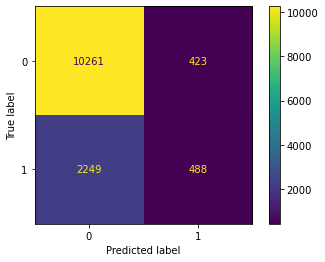

In [74]:
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test,labels = [0,1], values_format = '.0f')
plt.show()

In [77]:
#recall
predicted = log_reg.predict(X_test)
recall_score(y_test, predicted)
#Terrible recall, only able to identify about a sixth of the bot accounts in the test set

0.1782974059188893

In [78]:
#precision
precision_score(y_test, predicted)
#Precision is not good as well, performing about as well as a random classifier

0.535675082327113

In [89]:
#Repeat the above process, but this time instead of using bag of words vectors, we use tfidf vectors
tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 10)
#Create an array that contains the BOW representation of each tweet
tfidf_bow_array  = tfidf_vectorizer.fit_transform(tweets['sentence'])
#Converting the result into a pandas dataframe
tfidf_bow = pd.DataFrame(tfidf_bow_array.toarray(),columns = tfidf_vectorizer.get_feature_names_out())

In [90]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(tfidf_bow)

KMeans(n_clusters=2)

In [91]:
tweets['clusters_tfidf'] = kmeans.labels_

In [92]:
first_cluster_tfidf = tweets[tweets['clusters_tfidf'] == 1]

In [93]:
first_cluster_tfidf.account_type.value_counts()
#An interesting cluster where a third are bot tweets. But very small cluster relative to the rest of the dataset

human    288
bot      164
Name: account_type, dtype: int64

In [94]:
second_cluster_tfidf = tweets[tweets['clusters_tfidf'] == 0]

In [95]:

second_cluster_tfidf.account_type.value_counts()

human    42624
bot      10608
Name: account_type, dtype: int64

In [96]:
X = tfidf_bow
y = tweets[['account_type_numeric']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [97]:
log_reg = LogisticRegression(max_iter = 400)

log_reg.fit(X_train, y_train)

print("Training score: " + str(log_reg.score(X_train, y_train)))
print("Testing score: " + str(log_reg.score(X_test, y_test)))

C:\Users\veena\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training score: 0.822839828130045
Testing score: 0.8052306087474853


In [98]:
y_pred = log_reg.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[10534,   142],
       [ 2472,   273]], dtype=int64)

In [99]:
#Precision
precision_score(y_test, y_pred)
#Significantly better precision

0.6578313253012048

In [100]:
#recall
recall_score(y_test, y_pred)
#Even worse recall than before

0.0994535519125683